In [3]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, MaxPooling2D, Lambda
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D, LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
#import keras.backend as K

import os
import PIL
import PIL.Image

import random
import matplotlib.pyplot as plt
import sys
import numpy as np

import pathlib

In [11]:
print(tf.__version__)

2.7.0


In [4]:
data_dir = pathlib.Path("dataset")


In [12]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

7363


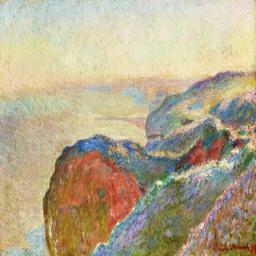

In [16]:
monet_jpgs = list(data_dir.glob('monet_jpg/*.jpg'))
PIL.Image.open(str(monet_jpgs[0]))

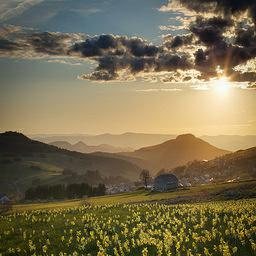

In [18]:
photo_jpgs = list(data_dir.glob('photo_jpg/*.jpg'))
PIL.Image.open(str(photo_jpgs[0]))